--> Verifying GPU availability...
     ✅ SUCCESS: Found 2 GPUs.
     ✅ SUCCESS: Number of devices in sync: 2
--> Dataset in 'tomato_dataset_unzipped' already found locally.
--> Dataset in 'intel_image_dataset_unzipped' already found locally.

--> Preparing data for the multi-class 'Tomato Disease Recognizer' model...
     Data already split for Septoria_leaf_spot. Skipping split.
     Data already split for Target_Spot. Skipping split.
     Data already split for Leaf_Mold. Skipping split.
     Data already split for healthy. Skipping split.
     Data already split for Early_blight. Skipping split.
     Data already split for Late_blight. Skipping split.
     Data already split for Spider_mites Two-spotted_spider_mite. Skipping split.
     Data already split for Tomato_Yellow_Leaf_Curl_Virus. Skipping split.
     Data already split for Tomato_mosaic_virus. Skipping split.
     Data already split for Bacterial_spot. Skipping split.
     Data already split for powdery_mildew. Skipping sp

Scanning Images: 100%|██████████| 21968/21968 [00:25<00:00, 857.17file/s] 



🚨 Scan Complete: Removed 1 corrupt file(s).
   The following files were deleted:
   - disease_classifier_data/train/healthy/edible-tomato-leaves.jpg

--> Creating TensorFlow datasets...
Found 18089 files belonging to 11 classes.
Found 3878 files belonging to 11 classes.
Found 3883 files belonging to 11 classes.
     ✅ Disease class names saved to class_names.txt

--> Building and compiling the model under MirroredStrategy scope...

--> Starting training...

--- Phase 1: Initial Training (Top Layers) ---
Epoch 1/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: nan - loss: nan
Epoch 1: val_loss improved from inf to 1.08795, saving model to tomato_disease_recognizer_best.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - accuracy: nan - loss: nan - val_accuracy: 0.6353 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 2/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: nan - loss: nan
Epoch 2: val_loss improved from 1.08795 to 0.88222, saving model to tomato_disease_reco

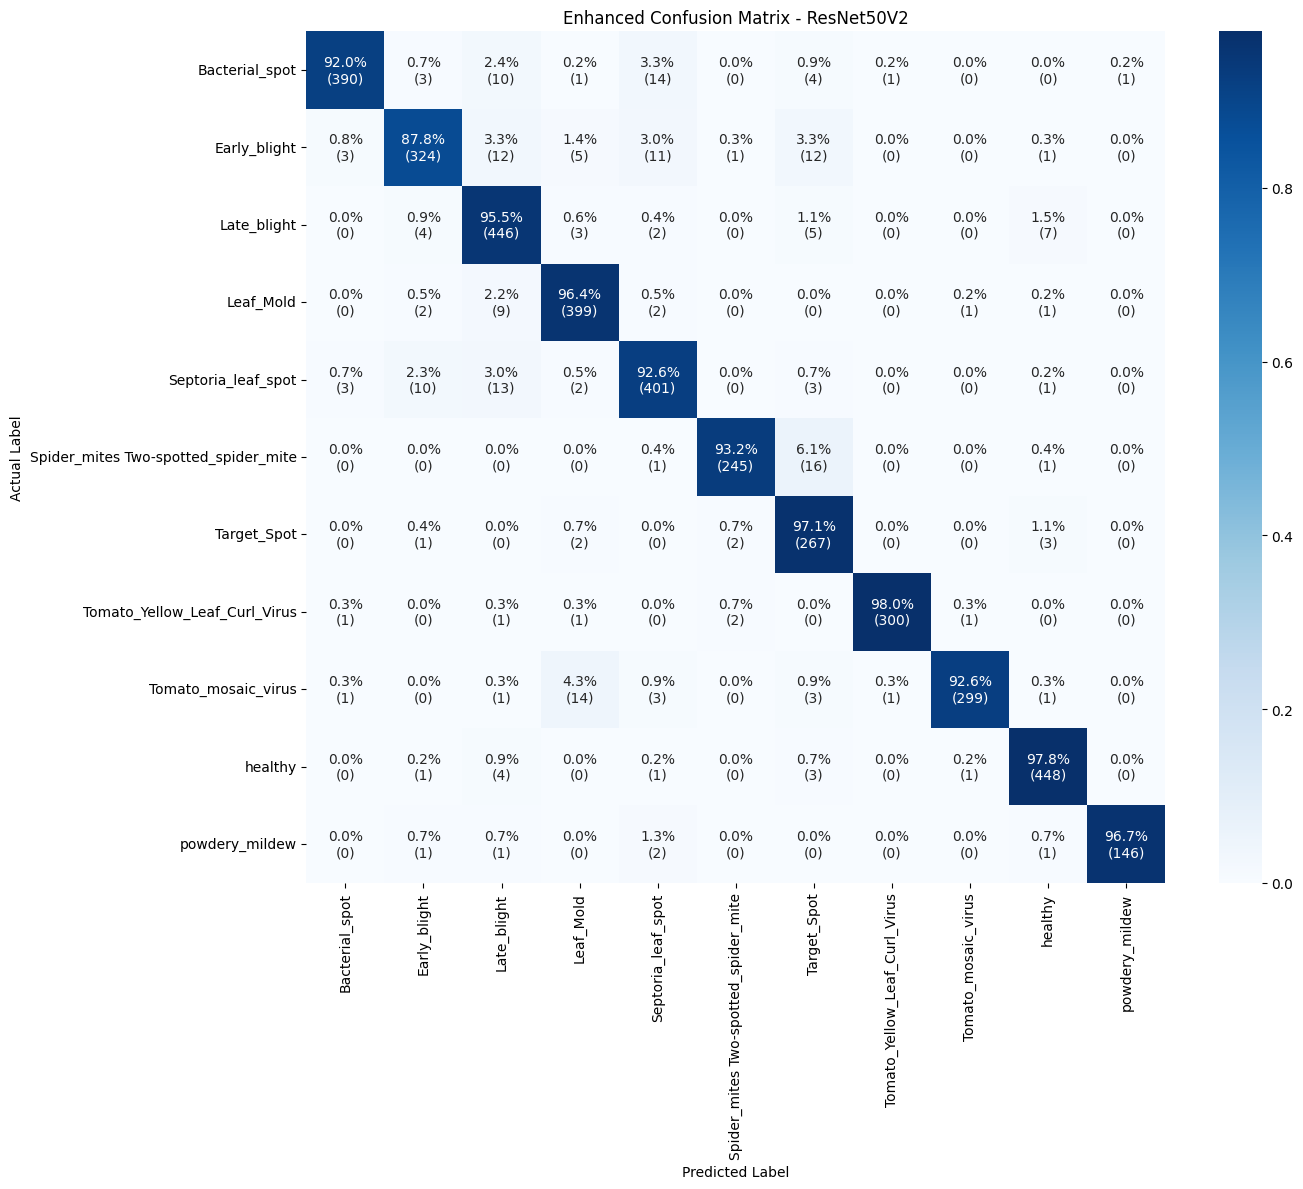


Final Test Accuracy - ResNet50V2: 94.39%


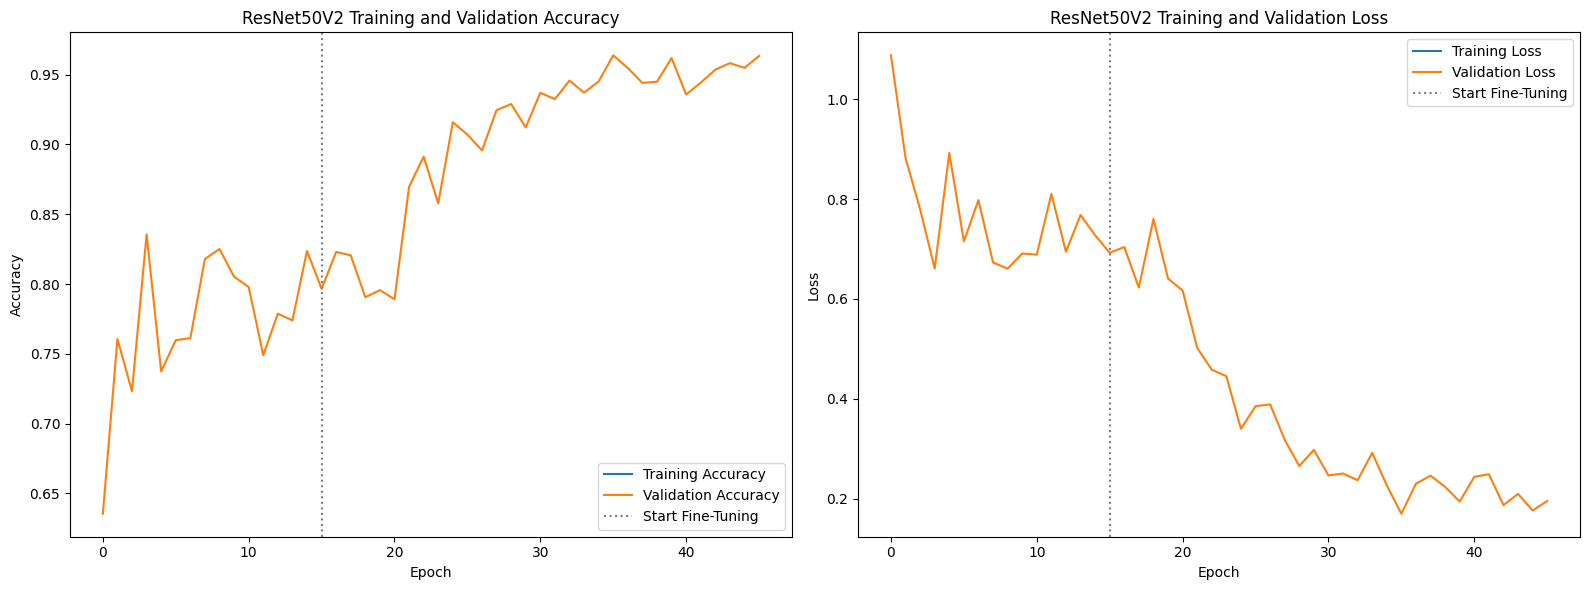

In [3]:
import os
import sys
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
import zipfile
from tqdm import tqdm

# --- 1. CONFIGURATION AND SETUP ---
# General settings
IMG_SIZE = (224, 224)
# CHANGED: Doubled the batch size for 2 GPUs
BATCH_SIZE = 64

# Training settings (maximums, EarlyStopping will likely stop it sooner)
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 30
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. GPU VERIFICATION AND MULTI-GPU STRATEGY ---
print("--> Verifying GPU availability...")
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 1:
    print(f"     ✅ SUCCESS: Found {len(gpus)} GPUs.")
else:
    print("     ⚠️ WARNING: Only one or no GPU found. MirroredStrategy will not provide a speedup.")

# For Multi-GPU: Create a MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy()
print(f'     ✅ SUCCESS: Number of devices in sync: {strategy.num_replicas_in_sync}')


# --- 3. UTILITY FUNCTIONS ---
def download_and_unzip_with_kagglehub(dataset_handle, target_dir):
    """
    Downloads a dataset from Kaggle using kagglehub and copies it to the target directory.
    """
    if os.path.exists(target_dir) and os.listdir(target_dir):
        print(f"--> Dataset in '{target_dir}' already found locally.")
        return

    print(f"\n--> Downloading and preparing dataset '{dataset_handle}'...")
    dataset_path = kagglehub.dataset_download(dataset_handle)
    
    print(f"    -> Copying dataset from {dataset_path} to '{target_dir}'...")
    # CORRECTED: Added dirs_exist_ok=True to prevent FileExistsError on reruns
    shutil.copytree(dataset_path, target_dir, dirs_exist_ok=True)
    
    print(f"     ✅ Dataset preparation complete for {target_dir}.")

def clean_image_dataset(root_directories):
    """
    Scans specified directories for corrupt image files and removes them.
    """
    print("--> Collecting all image files to scan...")
    all_image_paths = []
    image_extensions = ('.png', '.jpg', '.jpeg')
    for folder in root_directories:
        if not os.path.exists(folder):
            print(f"    - WARNING: Directory not found, skipping: {folder}")
            continue
        for root, _, files in os.walk(folder):
            for filename in files:
                if filename.lower().endswith(image_extensions):
                    all_image_paths.append(os.path.join(root, filename))

    if not all_image_paths:
        print("    - No image files found in the specified directories.")
        return

    print(f"    ✅ Found {len(all_image_paths)} images to verify.")

    removed_files = []
    print("\n--> Verifying images and removing corrupt files...")
    # The tqdm wrapper creates the progress bar
    for file_path in tqdm(all_image_paths, desc="Scanning Images", unit="file"):
        try:
            # The core of the check: try to decode the image
            image_bytes = tf.io.read_file(file_path)
            # We must decode to trigger the potential error
            tf.io.decode_image(image_bytes, channels=3)
        except tf.errors.InvalidArgumentError:
            # This error indicates a corrupt or malformed image file
            removed_files.append(file_path)
            os.remove(file_path) # Delete the problematic file
        except Exception as e:
            # Catch other potential file reading errors
            print(f"\n    - Error processing file {file_path}: {e}")
            removed_files.append(file_path)
            os.remove(file_path)

    print("\n" + "="*50)
    if not removed_files:
        print("✅ Scan Complete: All images are valid. No files were removed.")
    else:
        print(f"🚨 Scan Complete: Removed {len(removed_files)} corrupt file(s).")
        print("   The following files were deleted:")
        for path in removed_files:
            print(f"   - {path}")
    print("="*50)


def split_data(source_dir, train_dir, val_dir, test_dir, split_ratios=(0.7, 0.15, 0.15)):
    """Splits data from a source directory into train, validation, and test sets."""
    if os.path.exists(train_dir) and os.listdir(train_dir):
        print(f"     Data already split for {os.path.basename(source_dir)}. Skipping split.")
        return

    os.makedirs(train_dir, exist_ok=True); os.makedirs(val_dir, exist_ok=True); os.makedirs(test_dir, exist_ok=True)
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)
    train_split = int(len(files) * split_ratios[0])
    val_split = int(len(files) * (split_ratios[0] + split_ratios[1]))

    for f in files[:train_split]: shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in files[train_split:val_split]: shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, f))
    for f in files[val_split:]: shutil.copy(os.path.join(source_dir, f), os.path.join(test_dir, f))
    print(f"     Split {len(files)} images from {os.path.basename(source_dir)} into train/val/test.")

# --- 4. DATA PREPARATION ---
download_and_unzip_with_kagglehub('ashishmotwani/tomato', 'tomato_dataset_unzipped')
download_and_unzip_with_kagglehub('puneet6060/intel-image-classification', 'intel_image_dataset_unzipped')

# --- 4.1. Prepare data for Multi-Class Disease Classifier ---
print("\n--> Preparing data for the multi-class 'Tomato Disease Recognizer' model...")
disease_base_dir = 'disease_classifier_data'
disease_train_dir = os.path.join(disease_base_dir, 'train')
disease_val_dir = os.path.join(disease_base_dir, 'val')
disease_test_dir = os.path.join(disease_base_dir, 'test')

# CORRECTED PATH: Adjusted for the actual unzipped folder structure.
tomato_classes_source_dir = os.path.join('tomato_dataset_unzipped', 'train') 
for class_name in os.listdir(tomato_classes_source_dir):
    class_source_path = os.path.join(tomato_classes_source_dir, class_name)
    if os.path.isdir(class_source_path):
        split_data(
            class_source_path, 
            os.path.join(disease_train_dir, class_name), 
            os.path.join(disease_val_dir, class_name), 
            os.path.join(disease_test_dir, class_name)
        )

# --- 4.2. Clean Directories and Create TF Datasets ---
# FIX APPLIED HERE: Call the cleaning function on the final directories before creating datasets.
print("\n--> Verifying and cleaning final train and validation image sets...")
clean_image_dataset([disease_train_dir, disease_val_dir])

print("\n--> Creating TensorFlow datasets...")
disease_train_ds = tf.keras.utils.image_dataset_from_directory(
    disease_train_dir, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode='categorical'
)
disease_val_ds = tf.keras.utils.image_dataset_from_directory(
    disease_val_dir, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode='categorical'
)
disease_test_ds = tf.keras.utils.image_dataset_from_directory(
    disease_test_dir, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    label_mode='categorical'
)

class_names = disease_train_ds.class_names
with open('class_names.txt', 'w') as f:
    for item in class_names:
        f.write(f"{item}\n")
print("     ✅ Disease class names saved to class_names.txt")


# --- 5. MODEL ARCHITECTURE & TRAINING (WITH OVERFITTING PREVENTION & MULTI-GPU) ---
# Overfitting Prevention: Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Overfitting Prevention: Callbacks for smarter training
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='tomato_disease_recognizer_best.keras', save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

def create_disease_model():
    base_model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    # Overfitting Prevention: Added kernel regularization
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    model = tf.keras.Model(inputs, outputs, name='resnet50v2_disease_recognizer')
    return model, base_model

# For Multi-GPU: Build and compile the model inside the strategy's scope
with strategy.scope():
    print("\n--> Building and compiling the model under MirroredStrategy scope...")
    resnet_model, resnet_base = create_disease_model()
    
    initial_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    finetune_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    
    resnet_model.compile(optimizer=initial_optimizer, 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

def train_and_evaluate_model(model, base_model, train_ds, val_ds):
    print("\n--- Phase 1: Initial Training (Top Layers) ---")
    history = model.fit(train_ds, validation_data=val_ds, epochs=INITIAL_EPOCHS, callbacks=callbacks_list)

    print("\n--- Phase 2: Fine-Tuning (Unfreezing Base Model Layers) ---")
    base_model.trainable = True
    # Let's unfreeze the top 50 layers for fine-tuning
    fine_tune_at = -50 
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # For Multi-GPU: Re-compile for fine-tuning under the strategy scope
    with strategy.scope():
        model.compile(optimizer=finetune_optimizer, 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

    history_fine_tune = model.fit(train_ds, 
                                  validation_data=val_ds, 
                                  epochs=TOTAL_EPOCHS, 
                                  initial_epoch=len(history.epoch), 
                                  callbacks=callbacks_list)

    # Combine history objects
    history.history['accuracy'].extend(history_fine_tune.history['accuracy'])
    history.history['val_accuracy'].extend(history_fine_tune.history['val_accuracy'])
    history.history['loss'].extend(history_fine_tune.history['loss'])
    history.history['val_loss'].extend(history_fine_tune.history['val_loss'])
    return model, history

print("\n--> Starting training...")
resnet_model, history = train_and_evaluate_model(resnet_model, resnet_base, disease_train_ds, disease_val_ds)
print("     ✅ Training complete. Best model was saved to tomato_disease_recognizer_best.keras")


# --- 6. EVALUATION ---
print("\n--- MODEL EVALUATION ON TEST SET (USING BEST SAVED MODEL) ---")
# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model('tomato_disease_recognizer_best.keras')

# NEW: Enhanced function to plot a normalized confusion matrix with counts
def plot_enhanced_confusion_matrix(y_true, y_pred, model_name, class_names):
    """
    Plots a confusion matrix with both raw counts and normalized percentages.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Calculate normalized confusion matrix, handling division by zero for rows with no samples
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    
    # Create labels with both percentage and raw count
    labels = [f'{p:.1%}\n({c})' for p, c in zip(cm_normalized.flatten(), cm.flatten())]
    labels = np.asarray(labels).reshape(cm.shape)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_normalized, annot=labels, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Enhanced Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Get true labels and predictions from the test set
y_true = np.concatenate([y for x, y in disease_test_ds], axis=0)
y_true_indices = np.argmax(y_true, axis=1)

print("\n--- ResNet50V2 Performance ---")
preds = best_model.predict(disease_test_ds)
pred_indices = np.argmax(preds, axis=1)

# Print classification report
print(classification_report(y_true_indices, pred_indices, target_names=class_names))

# Call the enhanced plotting function
plot_enhanced_confusion_matrix(y_true_indices, pred_indices, "ResNet50V2", class_names)

final_accuracy = np.mean(tf.keras.metrics.categorical_accuracy(y_true, preds))
print(f"\nFinal Test Accuracy - ResNet50V2: {final_accuracy:.2%}")


# --- 7. PLOT TRAINING HISTORY ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs_trained = len(acc) - (TOTAL_EPOCHS - len(history.epoch))


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Check if fine-tuning phase was reached
if initial_epochs_trained < len(acc):
    plt.axvline(x=initial_epochs_trained - 1, color='grey', linestyle=':', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('ResNet50V2 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Check if fine-tuning phase was reached
if initial_epochs_trained < len(loss):
    plt.axvline(x=initial_epochs_trained - 1, color='grey', linestyle=':', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('ResNet50V2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

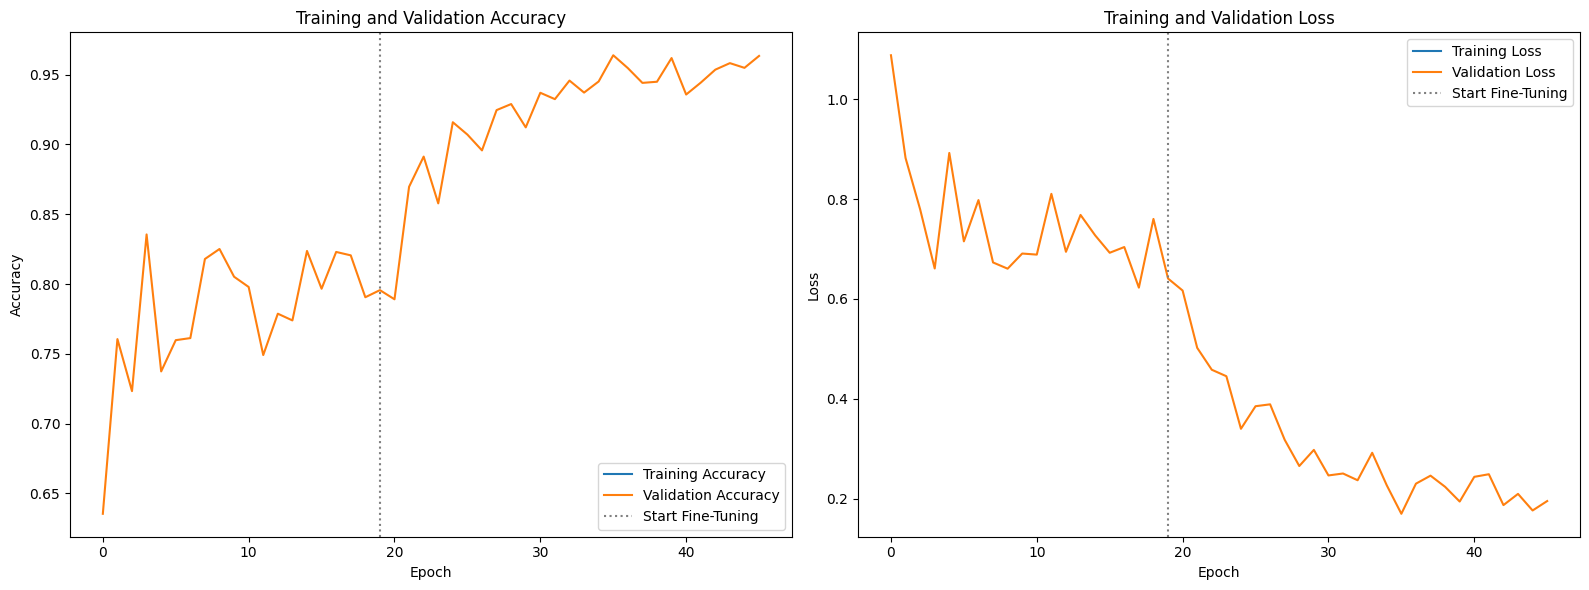

In [4]:
import matplotlib.pyplot as plt

# --- 1. EXTRACT DATA FROM THE HISTORY OBJECT ---
# The 'history' object should be the one returned by the final model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of initial epochs before fine-tuning started
# This is needed to draw the vertical line correctly.
INITIAL_EPOCHS = 20 
TOTAL_EPOCHS = len(acc) # Total epochs that actually ran

# --- 2. CREATE THE PLOTS ---
plt.figure(figsize=(16, 6))

# Plot for Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Add a vertical line to show the start of fine-tuning
if TOTAL_EPOCHS > INITIAL_EPOCHS:
    plt.axvline(x=INITIAL_EPOCHS - 1, color='grey', linestyle=':', label='Start Fine-Tuning')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot for Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add a vertical line to show the start of fine-tuning
if TOTAL_EPOCHS > INITIAL_EPOCHS:
    plt.axvline(x=INITIAL_EPOCHS - 1, color='grey', linestyle=':', label='Start Fine-Tuning')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# --- 3. DISPLAY THE PLOTS ---
plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

In [5]:
# --- 1. INSTALL THE LIBRARY ---
# This library allows us to interact with the Google Drive API
!pip install PyDrive2

# --- 2. AUTHENTICATE WITH GOOGLE ---
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("✅ Authentication successful.")


# --- 3. UPLOAD THE MODEL FILE 📤 ---
# Define the local path to your saved model and the desired filename in Drive
local_file_path = '/kaggle/working/tomato_disease_recognizer_best.keras'
drive_filename = 'tomato_disease_recognizer_best.keras'

# Create a GoogleDriveFile instance with the desired filename
file_to_upload = drive.CreateFile({'title': drive_filename})

# Set the content of the file to your local model file
file_to_upload.SetContentFile(local_file_path)

# Execute the upload
file_to_upload.Upload()

print(f"✅ Successfully uploaded '{file_to_upload['title']}' to Google Drive.")
print(f"File ID: {file_to_upload['id']}")

✅ Authentication successful.
✅ Successfully uploaded 'tomato_disease_recognizer_best.keras' to Google Drive.
File ID: 1za_lcOUx7bN2wY7VrhE2wlP1zaOj8Cbo
